# GTHA housing market database
# OSEMN methodology Step 3: Explore
# Explore correlations between the features and target classes
# Top 19 (18) selected features, fill NaN

Top 19 features without `pin_years_since_last_sale` and with NaN past/future xy sales filled with mean
future/past xy sales.

---

This notebook describes _Step 4: Model_ of OSEMN methodology performed on the Teranet dataset.

## Import dependencies

In [32]:
random_state = 1

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import pandas as pd
import os
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
# from pydotplus import graph_from_dot_data
from time import time

sns.set()

In [34]:
import sys

sys.path.append('../../src')

from io_utils import df_from_csv
from plot_utils import plot_hist, log_hist
from model_utils import fit_model, targets_corr 

## Load Teranet data

In [35]:
data_path = '../../data/'
teranet_path = data_path + 'teranet/'
os.listdir(teranet_path)

['4_Teranet_lu_predict.csv',
 '1.1_Teranet_DA.csv',
 '1.3_Teranet_DA_TAZ_PG_FSA.csv',
 '2_Teranet_consistent.csv',
 'parcel16_epoi13.csv',
 '1.2_Teranet_DA_TAZ.csv',
 '1.4_Teranet_DA_TAZ_FSA_LU_LUDMTI.csv',
 '4_Teranet_lu_predict.zip',
 '1.4_Teranet_DA_TAZ_FSA_LU.csv',
 '.ipynb_checkpoints',
 'ParcelLandUse.zip',
 'ParcelLandUse',
 'HHSaleHistory.csv',
 '3_Teranet_nonan_new_cols.csv',
 'GTAjoinedLanduseSales']

In [36]:
teranet_df = df_from_csv(teranet_path + '4_Teranet_lu_predict.csv', parse_dates=['registration_date'])

----- DataFrame loaded
in 125.88 seconds
with 5,188,513 rows
and 81 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction', 'municipality',
       'street_number', 'x', 'y', 'dauid', 'csduid', 'csdname', 'taz_o', 'fsa',
       'pca_id', 'postal_code_dmti', 'pin_lu', 'landuse', 'prop_code',
       'dmti_lu', 'street_name_raw', 'year', 'year_month', 'year3',
       'census_year', 'census2001_year', 'tts_year', 'tts1991_year', 'xy',
       'pin_total_sales', 'xy_total_sales', 'pin_prev_sales', 'xy_prev_sales',
       'xy_first_sale', 'pin_years_since_last_sale',
       'xy_years_since_last_sale', 'xy_years_to_next_sale',
       'da_days_since_last_sale', 'da_years_since_last_sale',
       'xy_sale_next_6m', 'price_2016', 'pin_price_cum_sum',
       'xy_price_cum_sum', 'pin_price_pct_change', 'xy_price_pct_change',
       'price_da_pct_chang

## Load Census data

In [37]:
census_path = data_path + 'census/'
os.listdir(census_path)

['da_census_income.csv',
 'Census data availability.xlsx',
 'da_census.xls',
 'da_census_select_tidy.csv',
 'da_census_income_shapefile',
 'da_census_select.csv']

In [38]:
census_df = df_from_csv(census_path + 'da_census_select_tidy.csv')

----- DataFrame loaded
in 0.15 seconds
with 36,728 rows
and 32 columns
-- Column names:
 Index(['DAUID', 'year', 'Avg_HHsize', 'Avg_HHinc', 'Avg_own_payt',
       'Avg_val_dwel', 'Avg_rent', 'Pop', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Apt_5plus', 'Sgl_att', 'Owned', 'Rented', 'CarTrVan_d',
       'CarTrVan_p', 'PT', 'Walk', 'Bike', 'Lbrfrc', 'Emp', 'Unemp',
       'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home', 'No_fix_wkpl',
       'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object')


## Load TTS data

In [39]:
tts_path = data_path + 'tts/'
os.listdir(tts_path)

['tts_num_jobs_tidy.csv',
 'TAZ_2001shp.zip',
 'TAZ_2001shp',
 'taz_tts_tidy.csv',
 'taz_info.csv',
 'TTS_variables.xlsx',
 'taz_tts.xlsx',
 'Num_of_Jobs.xlsx']

In [40]:
tts_df = df_from_csv(tts_path + 'taz_tts_tidy.csv')

----- DataFrame loaded
in 0.02 seconds
with 12,012 rows
and 8 columns
-- Column names:
 Index(['TAZ_O', 'year', 'Pop', 'FT_wrk', 'Stu', 'HH', 'Jobs', 'Cars'], dtype='object')


## Join Census data to Teranet data

In [41]:
t = time()
df = pd.merge(teranet_df, census_df, how='left',
              left_on=['dauid', 'census2001_year'], right_on=['DAUID', 'year'])
df = df.drop(['DAUID', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- Census variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- Census variables were joined to the DataFrame
in 52.49 seconds (0.87 minutes)
with 5,188,513 rows
and 111 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Emp', 'Unemp', 'Not_lbrfrc', 'Employee', 'Self_emp', 'At_home',
       'No_fix_wkpl', 'Usl_wkpl', 'Blue_cljob', 'White_cljob'],
      dtype='object', length=111)


## Join TTS data to Teranet data

In [42]:
t = time()
df = pd.merge(df, tts_df, how='left',
              left_on=['taz_o', 'tts_year'], right_on=['TAZ_O', 'year'])
df = df.drop(['taz_o', 'year_y'], axis=1).rename(columns={'year_x': 'year'})
elapsed = time() - t
print("----- TTS variables were joined to the DataFrame"
      "\nin {0:,.2f} seconds ({1:.2f} minutes)".format(elapsed, elapsed / 60) + 
      "\nwith {0:,} rows\nand {1:,} columns"
      .format(df.shape[0], df.shape[1]) + 
      "\n-- Column names:\n", df.columns)

----- TTS variables were joined to the DataFrame
in 57.44 seconds (0.96 minutes)
with 5,188,513 rows
and 117 columns
-- Column names:
 Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)


## Take a train-test subset of Teranet records

In [43]:
year_train_test = 2012
year_val1 = 2011
year_val2 = 2013

s = df.query('year == @year_train_test')
s_val1 = df.query('year == @year_val1')
s_val2 = df.query('year == @year_val2')

print("{0:,} Teranet records in the train-test subset (records from {1}).".format(len(s), year_train_test))
print("{0:,} Teranet records in the validation subset #1 (records from {1}).".format(len(s_val1), year_val1))
print("{0:,} Teranet records in the validation subset #2 (records from {1}).".format(len(s_val2), year_val2))

205,341 Teranet records in the train-test subset (records from 2012).
219,130 Teranet records in the validation subset #1 (records from 2011).
207,686 Teranet records in the validation subset #2 (records from 2013).


## Select features and fill missing values

In [44]:
s.columns

Index(['transaction_id', 'lro_num', 'pin', 'consideration_amt',
       'registration_date', 'postal_code', 'unitno', 'street_name',
       'street_designation', 'street_direction',
       ...
       'Usl_wkpl', 'Blue_cljob', 'White_cljob', 'TAZ_O', 'Pop_y', 'FT_wrk',
       'Stu', 'HH', 'Jobs', 'Cars'],
      dtype='object', length=117)

In [45]:
top19f_18 = ['xy_total_sales', 'xy_prev_sales', 
             'xy_years_since_last_sale', 'xy_years_to_next_sale', 'xy_sale_next_6m',
             'xy_price_cum_sum', 'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens',
             'Dwel', 'DwelDens', 'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars',
             'lucr_detached', 'lucr', 'lucr_duplex_townhouse',
             'lucr_condo', 'lucr_other']
s = s[top19f_18]
s_val1 = s_val1[top19f_18]
s_val2 = s_val2[top19f_18]
s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 23 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_years_since_last_sale    176503 non-null float64
xy_years_to_next_sale       137302 non-null float64
xy_sale_next_6m             205341 non-null bool
xy_price_cum_sum            205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
Dwel                        204722 non-null float64
DwelDens                    205341 non-null float64
Sgl_det                     204722 non-null float64
Sgl_att                     204722 non-null float64
PT                          204736 non-null float64
Walk                        204736 non-null float64
Jobs                        205324 non-null float64
Cars        

In [46]:
mask1 = s['xy_years_to_next_sale'].isnull()
s.loc[mask1, 'xy_years_since_last_sale'].mean()

7.589470289940691

In [47]:
mask1 = s['xy_years_since_last_sale'].isnull()
s.loc[mask1, 'xy_years_to_next_sale'].mean()

2.073792132299928

In [48]:
# missing year to next sale is replaced with mean year since last sale (for subset with missing year to next sale)
mask1 = s['xy_years_to_next_sale'].isnull()
s.loc[mask1, 'xy_years_to_next_sale'] = \
    s.loc[mask1, 'xy_years_to_next_sale'].fillna(s.loc[mask1, 'xy_years_since_last_sale']).mean()
mask1 = s_val1['xy_years_to_next_sale'].isnull()
s_val1.loc[mask1, 'xy_years_to_next_sale'] = \
    s_val1.loc[mask1, 'xy_years_to_next_sale'].fillna(s_val1.loc[mask1, 'xy_years_since_last_sale']).mean()
mask1 = s_val2['xy_years_to_next_sale'].isnull()
s_val2.loc[mask1, 'xy_years_to_next_sale'] = \
    s_val2.loc[mask1, 'xy_years_to_next_sale'].fillna(s_val2.loc[mask1, 'xy_years_since_last_sale']).mean()

# missing year since last sale is replaced with mean year to next sale (for subset with missing year since last sale)
mask1 = s['xy_years_since_last_sale'].isnull()
s.loc[mask1, 'xy_years_since_last_sale'] = \
    s.loc[mask1, 'xy_years_since_last_sale'].fillna(s.loc[mask1, 'xy_years_to_next_sale']).mean()
mask1 = s_val1['xy_years_since_last_sale'].isnull()
s_val1.loc[mask1, 'xy_years_since_last_sale'] = \
    s_val1.loc[mask1, 'xy_years_since_last_sale'].fillna(s_val1.loc[mask1, 'xy_years_to_next_sale']).mean()
mask1 = s_val2['xy_years_since_last_sale'].isnull()
s_val2.loc[mask1, 'xy_years_since_last_sale'] = \
    s_val2.loc[mask1, 'xy_years_since_last_sale'].fillna(s_val2.loc[mask1, 'xy_years_to_next_sale']).mean()

s.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 205341 entries, 0 to 205340
Data columns (total 23 columns):
xy_total_sales              205341 non-null int64
xy_prev_sales               205341 non-null int64
xy_years_since_last_sale    205341 non-null float64
xy_years_to_next_sale       205341 non-null float64
xy_sale_next_6m             205341 non-null bool
xy_price_cum_sum            205341 non-null float64
med_price_xy                205341 non-null float64
Avg_HHsize                  204722 non-null float64
Avg_rent                    204736 non-null float64
PopDens                     205341 non-null float64
Dwel                        204722 non-null float64
DwelDens                    205341 non-null float64
Sgl_det                     204722 non-null float64
Sgl_att                     204722 non-null float64
PT                          204736 non-null float64
Walk                        204736 non-null float64
Jobs                        205324 non-null float64
Cars        

In [49]:
s = s.dropna()
s_val1 = s_val1.dropna()
s_val2 = s_val2.dropna()
print("{0:,} rows in train-test subset, {1:,} rows in validation subset #1, {2:,} rows in validation subset #2"
      .format(len(s), len(s_val1), len(s_val2)))

204,705 rows in train-test subset, 217,943 rows in validation subset #1, 207,255 rows in validation subset #2


In [50]:
target_cols = 5
feat_cols = s.columns[:-target_cols]
feat_cols

Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_years_to_next_sale', 'xy_sale_next_6m', 'xy_price_cum_sum',
       'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars'],
      dtype='object')

In [51]:
feat_set_name = 'top19f_18_fillna'

## Encode target

In [52]:
le = LabelEncoder()

s['lucr_e'] = le.fit_transform(s['lucr'])
s_val1['lucr_e'] = le.transform(s_val1['lucr'])
s_val2['lucr_e'] = le.transform(s_val2['lucr'])

s['lucr_detached_e'] = le.fit_transform(s['lucr_detached'])
s_val1['lucr_detached_e'] = le.transform(s_val1['lucr_detached'])
s_val2['lucr_detached_e'] = le.transform(s_val2['lucr_detached'])

s['lucr_duplex_townhouse_e'] = le.fit_transform(s['lucr_duplex_townhouse'])
s_val1['lucr_duplex_townhouse_e'] = le.transform(s_val1['lucr_duplex_townhouse'])
s_val2['lucr_duplex_townhouse_e'] = le.transform(s_val2['lucr_duplex_townhouse'])

s['lucr_condo_e'] = le.fit_transform(s['lucr_condo'])
s_val1['lucr_condo_e'] = le.transform(s_val1['lucr_condo'])
s_val2['lucr_condo_e'] = le.transform(s_val2['lucr_condo'])

s['lucr_other_e'] = le.fit_transform(s['lucr_other'])
s_val1['lucr_other_e'] = le.transform(s_val1['lucr_other'])
s_val2['lucr_other_e'] = le.transform(s_val2['lucr_other'])

print(s['lucr'].value_counts().sort_index())
print(s['lucr_e'].value_counts().sort_index())
print(s_val1['lucr'].value_counts().sort_index())
print(s_val1['lucr_e'].value_counts().sort_index())
print(s_val2['lucr'].value_counts().sort_index())
print(s_val2['lucr_e'].value_counts().sort_index())

s = s.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val1 = s_val1.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
s_val2 = s_val2.drop(['lucr', 'lucr_detached', 'lucr_duplex_townhouse', 'lucr_condo', 'lucr_other'], axis=1)
print("Land use encoded!")
labels_list = ['condo', 'detached', 'duplex_townhouse', 'other']

condo               55527
detached            59670
duplex_townhouse    13251
other               76257
Name: lucr, dtype: int64
0    55527
1    59670
2    13251
3    76257
Name: lucr_e, dtype: int64
condo               62648
detached            60403
duplex_townhouse    13709
other               81183
Name: lucr, dtype: int64
0    62648
1    60403
2    13709
3    81183
Name: lucr_e, dtype: int64
condo               48276
detached            57104
duplex_townhouse    12539
other               89336
Name: lucr, dtype: int64
0    48276
1    57104
2    12539
3    89336
Name: lucr_e, dtype: int64
Land use encoded!


## Prepare features

In [53]:
def prep_features_val(df, df_val1, df_val2, feat_cols, target_col, norm=True, std=True, 
                      random_state=random_state, test_size=0.3, stratify=True):
    
    X = df[feat_cols].values
    X_val1 = df_val1[feat_cols].values
    X_val2 = df_val2[feat_cols].values
    
    y = df[target_col].values
    y_val1 = df_val1[target_col].values
    y_val2 = df_val2[target_col].values
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, 
                                                            random_state=random_state, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    print("Performed train-test split.")
    print('Labels counts in y:', np.bincount(y))
    print('Labels counts in y_train:', np.bincount(y_train))
    print('Labels counts in y_test:', np.bincount(y_test))
    print('Labels counts in y_val1:', np.bincount(y_val1))
    print('Labels counts in y_val2:', np.bincount(y_val2))

#### Select features and target

In [54]:
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values

In [55]:
X = s[feat_cols].values
X_val1 = s_val1[feat_cols].values
X_val2 = s_val2[feat_cols].values
y = s['lucr_e'].values
y_val1 = s_val1['lucr_e'].values
y_val2 = s_val2['lucr_e'].values
print("Features and target selected.")

Features and target selected.


#### Perform the train-test split

In [56]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state, stratify=y)
print("Performed train-test split.")
print('Labels counts in y:', np.bincount(y))
print('Labels counts in y_train:', np.bincount(y_train))
print('Labels counts in y_test:', np.bincount(y_test))
print('Labels counts in y_val1:', np.bincount(y_val1))
print('Labels counts in y_val2:', np.bincount(y_val2))

Performed train-test split.
Labels counts in y: [55527 59670 13251 76257]
Labels counts in y_train: [38869 41769  9275 53380]
Labels counts in y_test: [16658 17901  3976 22877]
Labels counts in y_val1: [62648 60403 13709 81183]
Labels counts in y_val2: [48276 57104 12539 89336]


#### Standardize features

In [57]:
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
X_val1_std = sc.transform(X_val1)
X_val2_std = sc.transform(X_val2)
print("Input features were standardized.")

Input features were standardized.


#### Normalize features

In [58]:
sc = MinMaxScaler()
sc.fit(X_train)
X_train_norm = sc.transform(X_train)
X_test_norm = sc.transform(X_test)
X_val1_norm = sc.transform(X_val1)
X_val2_norm = sc.transform(X_val2)
print("Input features were normalized.")

Input features were normalized.


## Estimate model fit times

In [5]:
def get_fit_times(model, X_train, y_train, X_test, y_test):
    
    fit_times = {}
    scores = {}
    
    tt = time()
    
    t = time()
    model.fit(X_train, y_train)
    fit_times['raw'] = time() - t
    scores['raw'] = model.score(X_)
    
    t = time()
    sc = MinMaxScaler()
    sc.fit_trans
    model.fit(X_train_norm, y_train)
    fit_times['norm'] = time() - t
    
    t = time()
    model.fit(X_train_std, y_train)
    fit_times['std'] = time() - t
    
    elapsed = time() - tt
    print("Model fit ({0} jobs), took {1:,.2f} seconds ({2:,.2f} minutes) in total."
          .format(n_jobs, elapsed, elapsed / 60))
    
    return fit_times
    pipe_norm = make_pipeline(MinMaxScaler(), model)

pipe_std = make_pipeline(StandardScaler(), model)
pipe.fit(X_train, y_train)
print('Test Accuracy: %.3f' % pipe_lr.score(X_test, y_test))

NameError: name 'model' is not defined

### Perceptron

In [62]:
fit_times_df = pd.DataFrame()

In [59]:
eta = 0.22
max_iter = 100
n_jobs = 8
model_name = 'ppn'
model = Perceptron(random_state=random_state, eta0=eta, max_iter=max_iter, n_jobs=n_jobs)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

TypeError: get_fit_times() missing 2 required positional arguments: 'X_test' and 'y_test'

### Logistic regression with L2 regularization

In [66]:
c = 0.1
penalty='l2'
n_jobs = 8
model_name = 'lr_{0}_c{1}'.format(penalty, c)

model = LogisticRegression(penalty=penalty, random_state=random_state, 
                           solver='lbfgs', multi_class='auto', C=c, n_jobs=n_jobs)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

Model fit (8 jobs), took 28.55 seconds (0.48 minutes) in total.


### Logistic regression with L1 regularization

In [68]:
c = 0.1
penalty='l1'
model_name = 'lr_{0}_c{1}'.format(penalty, c)

model = LogisticRegression(penalty=penalty, random_state=random_state, solver='liblinear', multi_class='auto', C=c)
fit_times = get_fit_times(model, X_train, y_train)
fit_times_df = fit_times_df.append(pd.DataFrame(fit_times, index=[model_name]))

/home/stepan/anaconda3/envs/gds/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Model fit (8 jobs), took 1,182.07 seconds (19.70 minutes) in total.


In [30]:
ax = fit_times_df.plot(kind='bar')
ax.set_ylim(20)

NameError: name 'fit_times_df' is not defined

## Outliers

### Temporal

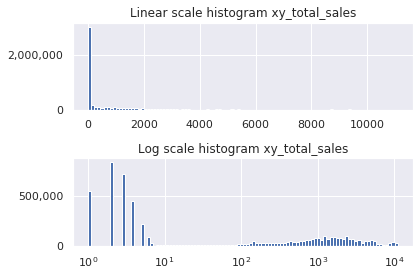

In [166]:
col_name = 'xy_total_sales'
log_hist(df[col_name], title=col_name, bins=100)

In [174]:
sns.catplot?

In [180]:
s.columns

Index(['xy_total_sales', 'xy_prev_sales', 'xy_years_since_last_sale',
       'xy_years_to_next_sale', 'xy_sale_next_6m', 'xy_price_cum_sum',
       'med_price_xy', 'Avg_HHsize', 'Avg_rent', 'PopDens', 'Dwel', 'DwelDens',
       'Sgl_det', 'Sgl_att', 'PT', 'Walk', 'Jobs', 'Cars', 'lucr_e',
       'lucr_detached_e', 'lucr_duplex_townhouse_e', 'lucr_condo_e',
       'lucr_other_e'],
      dtype='object')

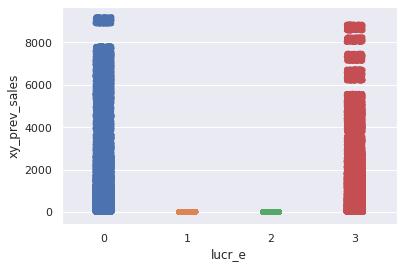

In [182]:
col = 'xy_prev_sales'
sns.stripplot(data=s, y=col, x='lucr_e')

TypeError: 'NoneType' object is not iterable

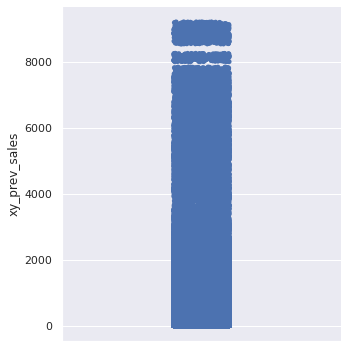

In [181]:
col = 'xy_prev_sales'
sns.catplot(data=s, y=col, hue='lucr_e')

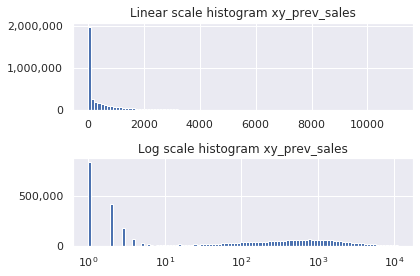

In [167]:
col = 'xy_prev_sales'
mask1 = df[col] != 0 # to plot the log scale
mask2 = df[col].isnull()
log_hist(df.loc[mask1 & ~mask2, col], title=col_name, bins=100)

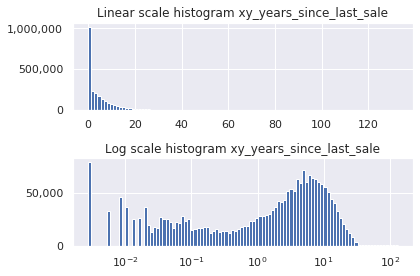

In [168]:
col_name = 'xy_years_since_last_sale'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

### Price

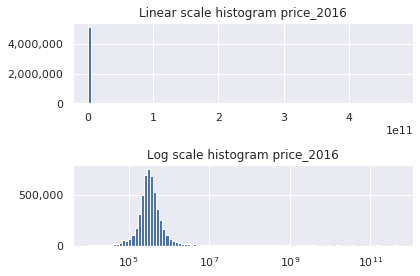

In [164]:
col_name = 'price_2016'
log_hist(df[col_name].dropna(), title=col_name, bins=100)

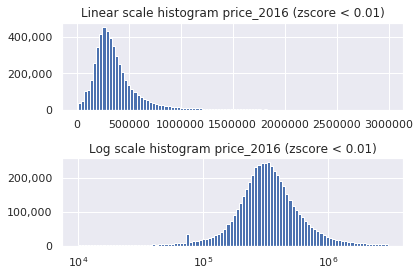

In [165]:
col_name = 'price_2016'
max_zscore = 0.01
mask1 = np.abs(stats.zscore(df[col_name].dropna())) < max_zscore
log_hist(df[col_name].dropna()[mask1], title=col_name + ' (zscore < {0})'.format(max_zscore), bins=100)

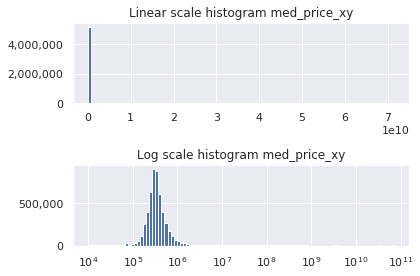

In [135]:
col_name = 'med_price_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

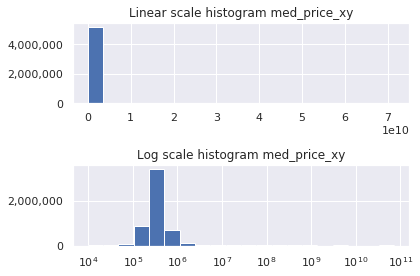

In [120]:
col_name = 'med_price_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=20)

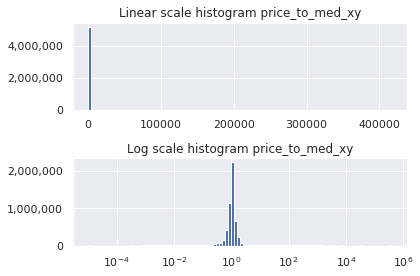

In [132]:
col_name = 'price_to_med_xy'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)

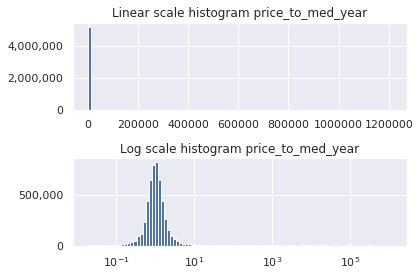

In [133]:
col_name = 'price_to_med_year'
mask1 = df[col_name] != 0 # to plot the log scale
mask2 = df[col_name].isnull()
log_hist(df.loc[mask1 & ~mask2, col_name], title=col_name, bins=100)